<a href="https://colab.research.google.com/github/RareDiseaseData/Meta-analysis-data/blob/main/simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read data

In [180]:
df_patient = pd.read_csv("content/Hyl_Patient_data.csv")
df_patient = df_patient[[
    'ID',
    'Cell1', # 1 fibroblast or 2 bone 
    'Age', 
    'Sex', 
    'Type', # severity of the pain (not linear)
    # 'n', 
    'Method', # quemistry method used for the extraction
    '%hydroxylysine_ind', # outcome for ipd
    # 'STD_n1', # within study std
    # 'STD_n2' # within study std within type
]]

df_control = pd.read_csv("content/Hyl_Control_data.csv")
df_control = df_control[[
    'ID',
    'Cell1', # 1 fibroblast or 2 bone 
    'Age', 
    'Sex', 
    'Type', # severity of the pain (not linear)
    # 'n', 
    'Method', # quemistry method used for the extraction
    '%hydroxylysine_ind', # outcome for ipd
    # 'STD_n1', # within study std
    # 'STD_n2' # within study std within type
]]

In [182]:
df_patient[df_patient.isna().any(axis=1)]

,ID,Cell1,Age,Sex,Type,Method,%hydroxylysine_ind


In [125]:
df = pd.concat([df_patient, df_control])
df

,ID,Cell1,Age,Sex,Type,n,Method,%hydroxylysine_ind
0,6,2,2,1,9,1.0,1,0.465116
1,8,2,1,1,2,1.0,2,0.219020
2,15,1,1,2,2,3.0,5,0.218750
3,15,2,1,2,2,NaN,3,0.371429
4,15,2,1,2,2,NaN,3,0.352941
...,...,...,...,...,...,...,...,...
42,207,1,5,3,10,NaN,7,0.243000
43,243,1,2,3,10,NaN,7,0.198000
44,265,1,5,3,10,NaN,7,0.235000
45,352,1,5,3,10,NaN,7,0.210000


## Preprocessing

In [126]:
df.columns

Index(['ID', 'Cell1', 'Age', 'Sex', 'Type', 'n', 'Method',
       '%hydroxylysine_ind'],
      dtype='object')

In [127]:
df_sel = df.copy()

We suppose two articles have irregularities.

In [128]:
df_sel[df_sel.ID == 61] # aggregate; maybe something went wrong here

,ID,Cell1,Age,Sex,Type,n,Method,%hydroxylysine_ind
15,61,1,2,3,1,3.0,5,0.129901
16,61,1,1,3,2,5.0,5,0.260990
17,61,1,5,3,3,12.0,5,0.140198
18,61,1,5,3,4,3.0,5,0.121188
19,61,2,2,3,1,3.0,3,0.134257
20,61,2,1,3,2,5.0,3,0.271683
21,61,2,5,3,3,12.0,3,0.114455
22,61,2,5,3,4,3.0,3,0.152079
14,61,1,1,3,10,2.0,5,0.189307
15,61,1,4,3,10,8.0,5,0.123168


In [129]:
df_sel[df_sel.ID == 75] # Did not report the method, values significantly lower
df_sel.loc[df_sel.ID == 75, 'Method'] = -1
df_sel[df_sel.ID == 75]

,ID,Cell1,Age,Sex,Type,n,Method,%hydroxylysine_ind
24,75,1,3,3,9,3.0,-1,0.241
25,75,1,1,3,9,NaN,-1,0.196
26,75,1,4,3,9,NaN,-1,0.151
20,75,1,3,3,10,3.0,-1,0.125
21,75,1,1,3,10,NaN,-1,0.146
22,75,1,4,3,10,NaN,-1,0.134


In [130]:
idx = df_sel.loc[(df_sel.ID == 61) | (df_sel.ID == 75)].index
df_sel['errors'] = 'Others'
df_sel.loc[df_sel.ID == 61, 'errors'] = '61'
df_sel.loc[df_sel.ID == 75, 'errors'] = '75'

## Outlier detection

- [x] Reason to remove them (Priyesh)

Grubb's Test
- [ ] https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/
- [ ] https://towardsdatascience.com/5-outlier-detection-methods-that-every-data-enthusiast-must-know-f917bf439210

- DBSCAN

In [151]:
def grubbs_test(x, x_test):
    m = x.mean()
    std = x.std()
    g = (x - m) / std
    return abs(g)

In [153]:
from outliers import smirnov_grubbs as grubbs

In [174]:
len(df_patient['%hydroxylysine_ind'].values)

69

In [175]:
df_sel['%hydroxylysine_ind']
len(grubbs.test(df_patient['%hydroxylysine_ind'].values, alpha = 0.1))

69

In [131]:
a = df_sel[df_sel['Type'] == 9].ID

In [132]:
df_sel[df_sel.ID.isin(a)].sort_values('ID')

,ID,Cell1,Age,Sex,Type,n,Method,%hydroxylysine_ind,errors
0,6,2,2,1,9,1.0,1,0.465116,Others
0,6,2,2,1,10,NaN,1,0.395257,Others
13,46,1,5,3,9,1.0,5,0.365854,Others
12,46,1,5,3,10,NaN,5,0.239825,Others
24,75,1,3,3,9,3.0,-1,0.241000,75
25,75,1,1,3,9,NaN,-1,0.196000,75
26,75,1,4,3,9,NaN,-1,0.151000,75
20,75,1,3,3,10,3.0,-1,0.125000,75
21,75,1,1,3,10,NaN,-1,0.146000,75
22,75,1,4,3,10,NaN,-1,0.134000,75


In [133]:
df_sel.Type.value_counts().sort_index()

1      9
2     19
3     17
4     18
9      6
10    47
Name: Type, dtype: int64

We are dropping the 6 patients that have OI type 9 because that is unknown (equal to NaN or NULL). 

In [134]:
df_sel = df_sel.drop(a.index)
df_sel

,ID,Cell1,Age,Sex,Type,n,Method,%hydroxylysine_ind,errors
1,8,2,1,1,2,1.0,2,0.219020,Others
2,15,1,1,2,2,3.0,5,0.218750,Others
3,15,2,1,2,2,NaN,3,0.371429,Others
4,15,2,1,2,2,NaN,3,0.352941,Others
5,25,1,1,1,2,2.0,5,0.294000,Others
...,...,...,...,...,...,...,...,...,...
42,207,1,5,3,10,NaN,7,0.243000,Others
43,243,1,2,3,10,NaN,7,0.198000,Others
44,265,1,5,3,10,NaN,7,0.235000,Others
45,352,1,5,3,10,NaN,7,0.210000,Others


## Roadmap

- [x] Empirical distribution (https://machinelearningmastery.com/empirical-distribution-function-in-python/)

##############################

- [ ] Check distribution of each column (normal, Bernoulli (maybe others))
- [ ] Generate data based on those distributions 🙂

##############################

- [ ] Statistical test for normality

- [ ] Get mean and std if normal and simulate data from those values

- [ ] Oversampling methods (SMOTE)

- [ ] Clusters or Groups

  - [ ] Apply some techniques for simulate data from above

##############################

- [ ] sample (increase variability)
- [ ] see distribution
- [ ] randomize

##############################

- [x] add control patient data -> put type = 0
- [ ] determine OI type for type 9 patients based on other records
- [ ] convert type to categorical
- [ ] check distributions

## Base dataframe

In [135]:
df_base = df_sel[[
  'ID',
  'Cell1',
  'Age',
  'Sex',
  'Type',
  'Method',
  '%hydroxylysine_ind',
  'errors'
]]
df_base

,ID,Cell1,Age,Sex,Type,Method,%hydroxylysine_ind,errors
1,8,2,1,1,2,2,0.219020,Others
2,15,1,1,2,2,5,0.218750,Others
3,15,2,1,2,2,3,0.371429,Others
4,15,2,1,2,2,3,0.352941,Others
5,25,1,1,1,2,5,0.294000,Others
...,...,...,...,...,...,...,...,...
42,207,1,5,3,10,7,0.243000,Others
43,243,1,2,3,10,7,0.198000,Others
44,265,1,5,3,10,7,0.235000,Others
45,352,1,5,3,10,7,0.210000,Others


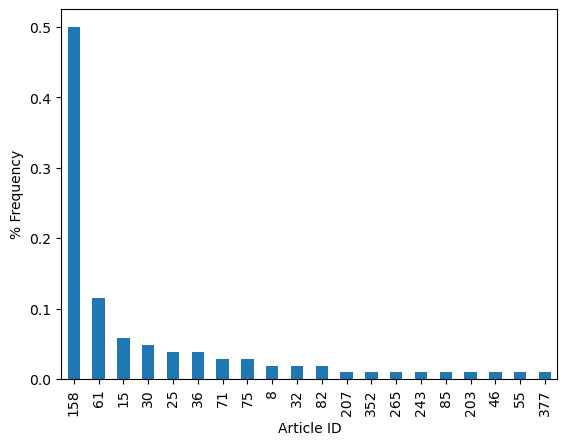

In [136]:
df_base['ID'].value_counts()

plt.figure()
freq = df_base['ID'].value_counts() / sum(df_base['ID'].value_counts())
freq.plot(kind = 'bar')
plt.xlabel('Article ID')
plt.ylabel('% Frequency')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_47952\606909762.py:6: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.displot(
C:\Users\user\AppData\Local\Temp\ipykernel_47952\606909762.py:6: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.displot(
C:\Users\user\AppData\Local\Temp\ipykernel_47952\606909762.py:6: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.displot(
C:\Users\user\AppData\Local\Temp\ipykernel_47952\606909762.py:6: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.displot(


C:\Users\user\AppData\Local\Temp\ipykernel_47952\606909762.py:6: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.displot(
C:\Users\user\AppData\Local\Temp\ipykernel_47952\606909762.py:6: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.displot(


<Figure size 400x200 with 0 Axes>

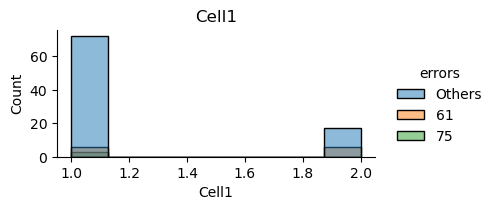

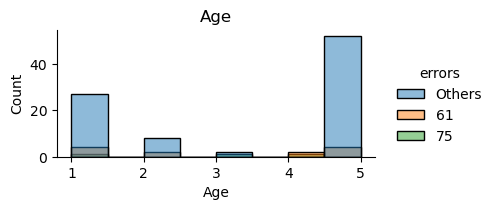

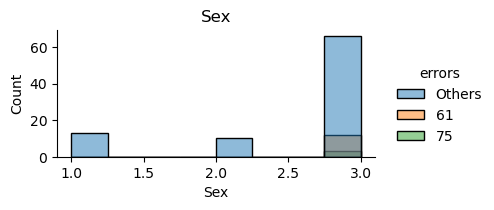

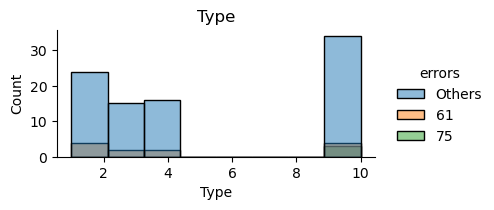

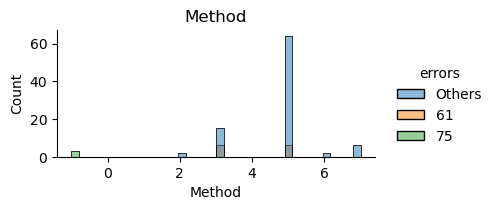

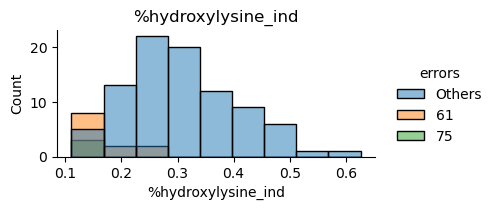

In [137]:
columns = [
    'Cell1', 'Age', 'Sex', 'Type', 'Method', '%hydroxylysine_ind'
]
plt.figure(figsize=(4,2))
for c in columns:
    sns.displot(
        df_base, x = c, 
        hue="errors",
        palette = sns.color_palette(),
        height = 2,
        aspect=2
    )
    plt.title(c)
plt.show()

- [ ] Sex seems odd.What does the values mean?

In [138]:
df_base.Sex.unique()

array([1, 2, 3], dtype=int64)

- [ ] Dropping Sex and Age because they have too much imputated data.

In [139]:
df_base = df_base[[
    'ID',
    'Cell1',
    'Age',
    'Sex',
    'Type',
    'Method',
    '%hydroxylysine_ind',
    'errors'
]]
df_base

,ID,Cell1,Age,Sex,Type,Method,%hydroxylysine_ind,errors
1,8,2,1,1,2,2,0.219020,Others
2,15,1,1,2,2,5,0.218750,Others
3,15,2,1,2,2,3,0.371429,Others
4,15,2,1,2,2,3,0.352941,Others
5,25,1,1,1,2,5,0.294000,Others
...,...,...,...,...,...,...,...,...
42,207,1,5,3,10,7,0.243000,Others
43,243,1,2,3,10,7,0.198000,Others
44,265,1,5,3,10,7,0.235000,Others
45,352,1,5,3,10,7,0.210000,Others


Empty values that can be droped. None.

In [94]:
df_base[df_base.isna().any(axis=1)]

,ID,Cell1,Type,Method,%hydroxylysine_ind,errors


## Prediction

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as RMSE

import xgboost as xgb

In [96]:
df_base.columns

Index(['ID', 'Cell1', 'Type', 'Method', '%hydroxylysine_ind', 'errors'], dtype='object')

In [98]:
x_col = [
    'Cell1',
    'Age',
    'Sex',
    'Type',
    'Method']
y_col = ['%hydroxylysine_ind']

### Train and test split

In [99]:
x_train, x_test, y_train, y_test = train_test_split(df_base[x_col], df_base[y_col], test_size = 0.3)

### Best result by random folds

In [100]:
xgb_r = xgb.XGBRegressor()

cv = RepeatedKFold(n_splits=10, n_repeats=3)
# evaluate model
scores = cross_val_score(xgb_r, df_sel[x_col], df_sel[y_col], scoring='neg_mean_absolute_percentage_error', cv = cv, n_jobs = -1)
scores = abs(scores)
print('Mean MAPE: %.3f; Sdv MAPE: %.3f' % (scores.mean(), scores.std()) )

Mean MAPE: 0.255; Sdv MAPE: 0.101


### GridSearch

- [ ] DOE for explore the best values instead of only doing a GridSearchCV

In [101]:
# https://machinelearningmastery.com/xgboost-for-regression/
xgb_r = xgb.XGBRegressor(eval_metric = 'rmsle')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
param_grid = {
    "max_depth" :    [4, 5, 6],
    "n_estimators" : [600, 700, 800],
    "learning_rate" : [0.05, 0.1, 0.15],
    # "colsample_bytree" : [1, 5/6, 4/6, 3/6]
}

# try out every combination of the above values
search = GridSearchCV(xgb_r, param_grid, cv = cv).fit(x_train, y_train)

print("The best hyperparameters are ", search.best_params_)

The best hyperparameters are  {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 600}


In [106]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,0.124940,0.010724,0.003105,0.000525,0.05,4,600,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",-0.204088,0.297535,...,-0.108803,0.377131,0.413786,-0.028253,0.112258,-0.162864,0.363707,-0.184059,1.521568,4
1,0.143444,0.006511,0.002904,0.000571,0.05,4,700,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",-0.204088,0.297535,...,-0.108803,0.377131,0.413786,-0.028253,0.112258,-0.162864,0.363707,-0.184059,1.521568,4
2,0.171823,0.015359,0.002906,0.000689,0.05,4,800,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",-0.204088,0.297535,...,-0.108803,0.377131,0.413786,-0.028253,0.112258,-0.162864,0.363707,-0.184059,1.521568,4
3,0.128333,0.017362,0.002853,0.000468,0.05,5,600,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",-0.249771,0.296364,...,-0.109230,0.364800,0.412809,-0.098685,0.110325,-0.178207,0.363512,-0.191245,1.522942,16
4,0.150133,0.022149,0.002921,0.000532,0.05,5,700,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",-0.249771,0.296364,...,-0.109230,0.364800,0.412809,-0.098685,0.110325,-0.178207,0.363512,-0.191245,1.522942,16
5,0.171033,0.023443,0.002805,0.000479,0.05,5,800,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",-0.249771,0.296364,...,-0.109230,0.364800,0.412809,-0.098685,0.110325,-0.178207,0.363512,-0.191245,1.522942,16
6,0.131146,0.004262,0.002870,0.000482,0.05,6,600,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",-0.240069,0.295615,...,-0.108820,0.365526,0.412750,-0.092915,0.109000,-0.191642,0.364385,-0.192448,1.523837,22
7,0.152552,0.006399,0.003271,0.001584,0.05,6,700,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",-0.240069,0.295615,...,-0.108820,0.365526,0.412750,-0.092915,0.109000,-0.191642,0.364385,-0.192448,1.523837,22
8,0.170902,0.014162,0.002888,0.000602,0.05,6,800,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",-0.240069,0.295615,...,-0.108820,0.365526,0.412750,-0.092915,0.109000,-0.191642,0.364385,-0.192448,1.523837,22
9,0.115817,0.004093,0.002854,0.000470,0.1,4,600,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",-0.208710,0.296688,...,-0.110826,0.382168,0.412537,-0.022608,0.112245,-0.161494,0.362980,-0.185035,1.528866,7


In [119]:
d = []
for r in range(10):
    for test_size in [0.1, 0.2, 0.3, 0.4]:
        x_train, x_test, y_train, y_test = train_test_split(df_sel[x_col], df_sel[y_col], test_size = 0.2)
        xgb_r = xgb.XGBRegressor(
            max_depth     = search.best_params_["max_depth"],
            n_estimators  = search.best_params_["n_estimators"],
            learning_rate = search.best_params_["learning_rate"],
            # colsample_bytree = search.best_params_["colsample_bytree"],
            eval_metric='rmsle'
        )

        xgb_r.fit(x_train, y_train)
        y_pred = xgb_r.predict(x_test)
        mape = np.sqrt(MAPE(y_test, y_pred))
        # print(f"MAPE: {round(mape, 4)}")

        rmse = np.sqrt(RMSE(y_test, y_pred))
        # print(f"RMSE: {round(rmse, 4)}")
        
        d.append({
            'r' : r,
            'test_size' : test_size,
            'mape' : mape
        })

In [121]:
pd.DataFrame(d)

,r,test_size,mape
0,0,0.1,0.542354
1,0,0.2,0.491802
2,0,0.3,0.531919
3,0,0.4,0.624551
4,1,0.1,0.576395
5,1,0.2,0.490373
6,1,0.3,0.422376
7,1,0.4,0.490598
8,2,0.1,0.470141
9,2,0.2,0.601111


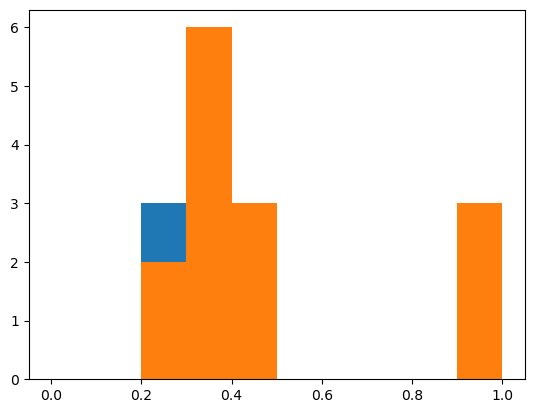

In [163]:
plt.hist(y_test, bins = [x * 0.1 for x in list(range(0, 11))])
plt.hist(y_pred, bins = [x * 0.1 for x in list(range(0, 11))])
plt.show()

## Empirical simulation

### Unit test

In [106]:
df_base['ID'].value_counts()

158    39
61      8
30      4
15      3
75      3
25      2
6       1
8       1
32      1
36      1
46      1
55      1
71      1
82      1
85      1
144     1
Name: ID, dtype: int64

<Axes: >

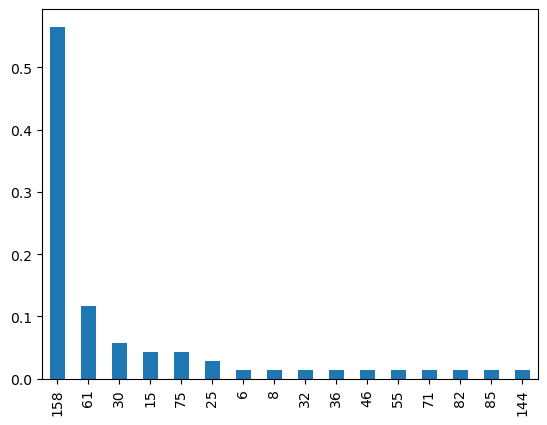

In [108]:
freq = df_base['ID'].value_counts() / sum(df_base['ID'].value_counts())
freq.plot(kind = 'bar')

In [113]:
np.random.choice(  
  a = df_base['ID'].value_counts().index,
  size = 50,
  p = df_base['ID'].value_counts() / sum(df_base['ID'].value_counts())
)

array([144, 158,  82,  15, 158, 158,  82, 158, 158,  55, 158,  36, 158,
       158,  55,  61,  30, 158, 158, 158, 158,  36, 144, 158,  71,  61,
         8, 158,  55,  32, 158,  30, 158,  30,  25,  30, 158, 158, 158,
        75, 158, 158,  85, 158,  46,  25, 158, 158, 158, 158], dtype=int64)

## Reconstruction method

In [167]:
from imblearn.combine import SMOTEENN

### Model

In [168]:
def empirical_simulator(df, col, n):
  df[col].value_counts()
  simulated_data = np.random.choice(  
    a = df[c].value_counts().index,
    size = n,
    p = df[c].value_counts() / sum(df[c].value_counts())
  )
  return simulated_data

### Simulated data

In [169]:
new_data = {}
for c in df_final.columns:
  new_data[c] = empirical_simulator(df_final, c, 1000)
df_empirical_simulated = pd.DataFrame(new_data)

### Visualization

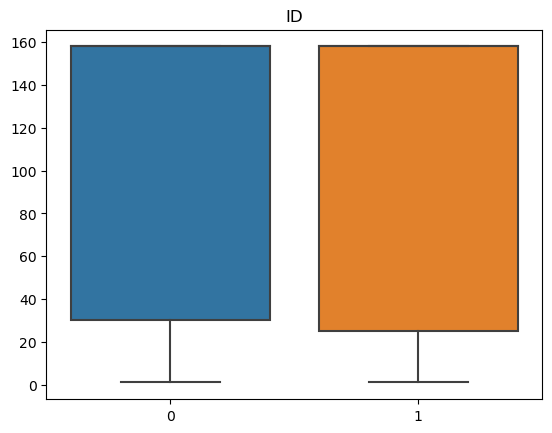

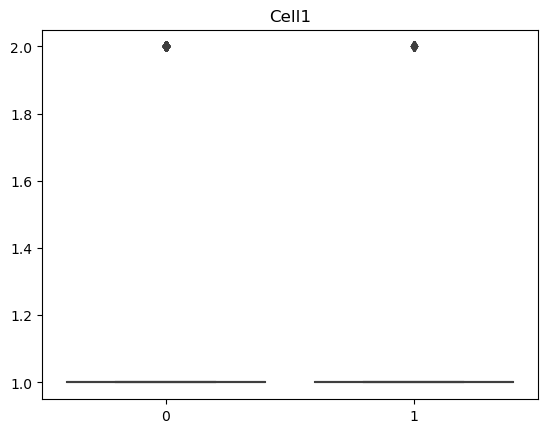

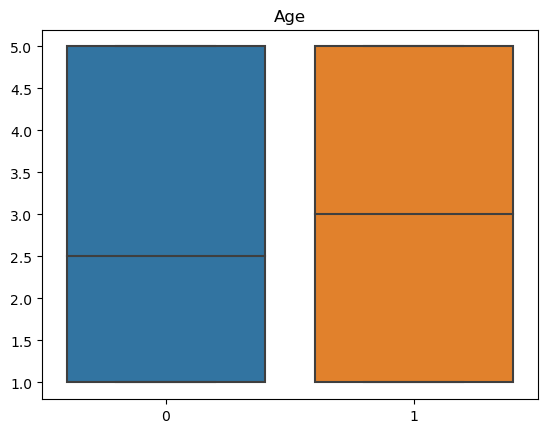

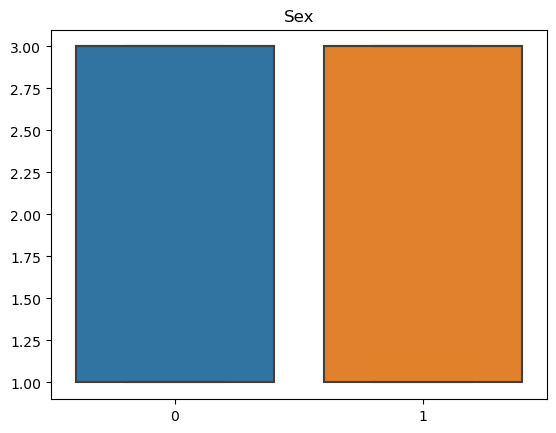

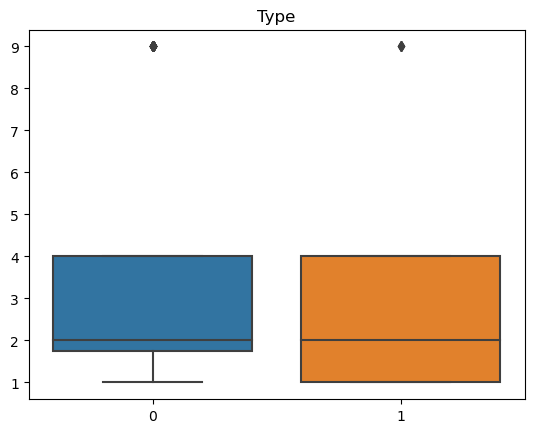

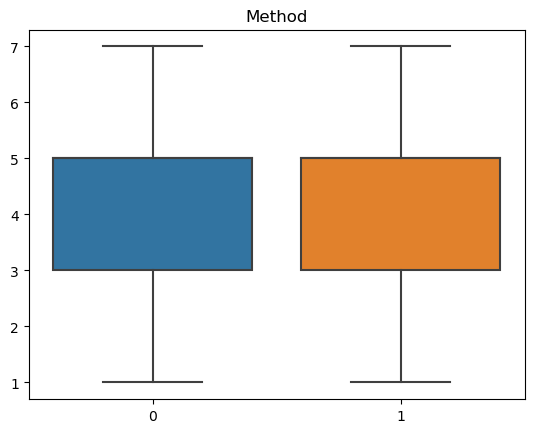

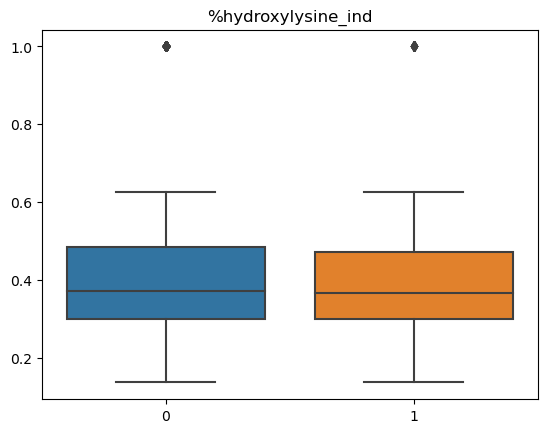

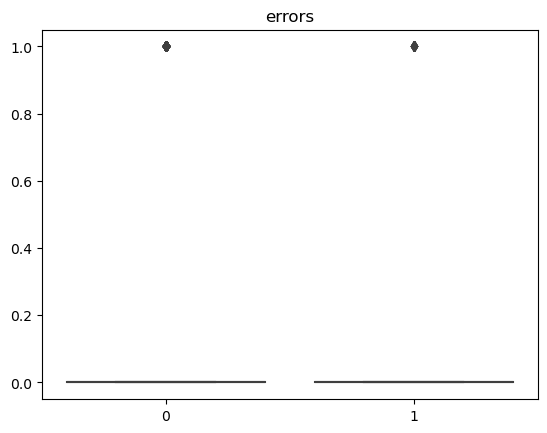

In [170]:
for c in df_final.columns:
  plt.figure()
  plt.title(c)
  sns.boxplot(
    data=[df_empirical_simulated[c], df_final[c]])
  plt.show()

## Normality simulation

In [171]:
import pingouin as pg

In [172]:
df_final.columns

Index(['ID', 'Cell1', 'Age', 'Sex', 'Type', 'Method', '%hydroxylysine_ind',
       'errors'],
      dtype='object')

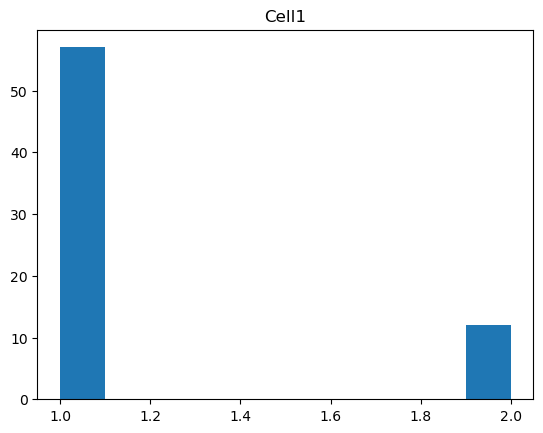

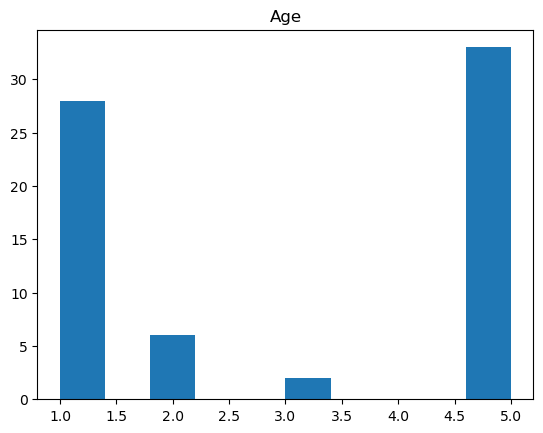

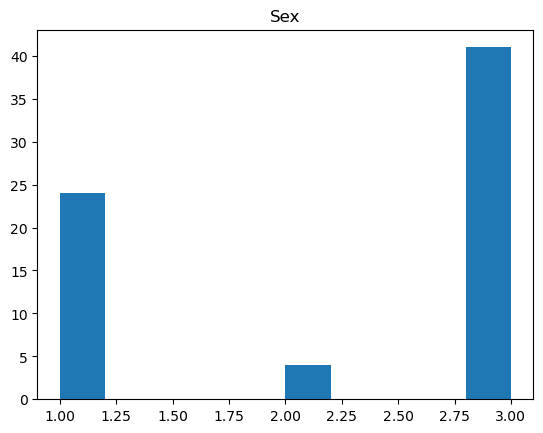

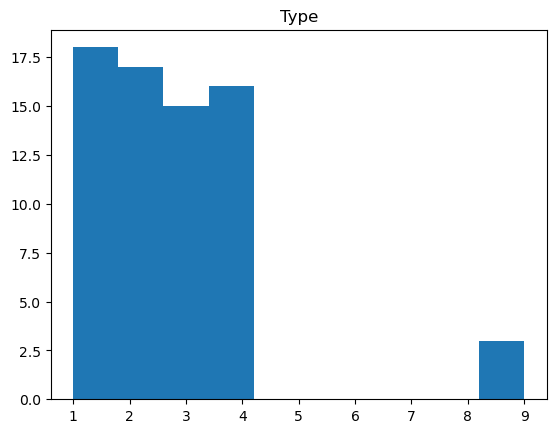

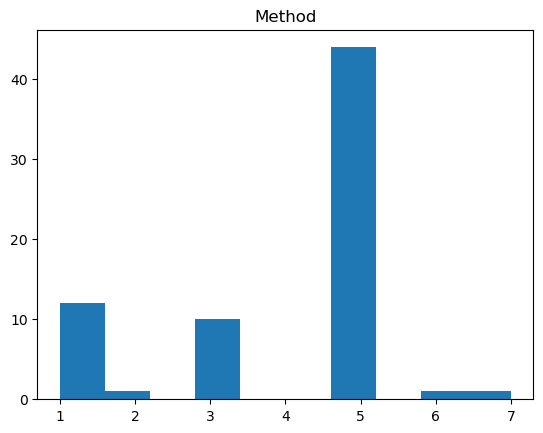

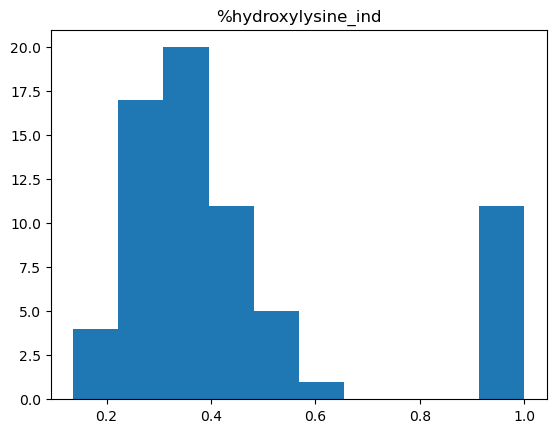

In [173]:
for c in ['Cell1', 'Age', 'Sex', 'Type', 'Method', '%hydroxylysine_ind']:
    plt.figure()
    plt.hist(df_final[c])
    plt.title(c)
    plt.show()

In [174]:
df_final.Sex.unique()

array([1, 2, 3], dtype=int64)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

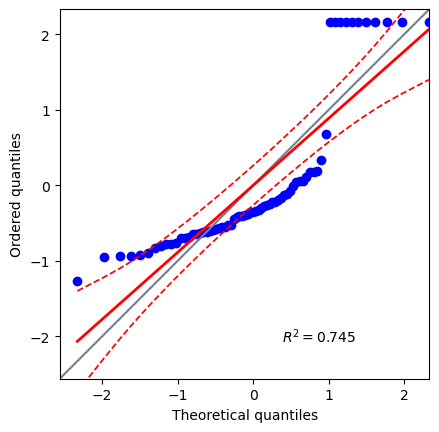

In [175]:
pg.qqplot(df_final['%hydroxylysine_ind'], dist='norm')

In [176]:
print(pg.normality(df_final['%hydroxylysine_ind']))

                           W          pval  normal
%hydroxylysine_ind  0.739249  9.521427e-10   False


In [177]:
import statsmodels.api as sm

In [178]:
model = sm.OLS(
    df_final['%hydroxylysine_ind'],
    df_final[['Cell1', 'Age', 'Sex', 'Type', 'Method', '%hydroxylysine_ind']]
)

In [179]:
results = model.fit()
results.params

Cell1                -1.387779e-17
Age                  -3.122502e-17
Sex                   8.326673e-17
Type                  1.804112e-16
Method               -1.075529e-16
%hydroxylysine_ind    1.000000e+00
dtype: float64